In [ ]:
!pip install -qq -U transformers


In [ ]:
!pip install -qq -U transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [ ]:
from torch.optim import AdamW

In [ ]:
import os
import re
import string
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import numpy as np
import pickle
os.system('pip install -qq transformers')
os.system('pip install -q -U watermark')
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup # Remove AdamW from here
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 7.34.0

numpy       : 2.0.2
pandas      : 2.2.2
torch       : 2.6.0+cu124
transformers: 4.51.3



In [ ]:
df_train = pd.read_csv('/content/tweets-train.csv')
df_test = pd.read_csv('/content/tweets-test.csv')
df_valid = pd.read_csv('/content/tweets-valid.csv')

In [ ]:

df_train.head(10)

,tweet,label
0,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे व...,-1
1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिस...,-1
2,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांच...,-1
3,आपला समाज खूप मोठा आहे. त्यात अनेक घटक अंतर्भू...,1
4,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म...,-1
5,जरी मी देशाच्या सेवेत मृत्यू पावली तरी मला त्य...,1
6,"आज, बारामती शहर परिसरात सुरु असणाऱ्या विविध वि...",1
7,च्या माजी अध्यक्ष स्व. प्रभाताई राव यांना जयंत...,1
8,पालखी सोहळ्यात अपघात झाल्याची बातमी दुःखद आहे....,-1
9,आगामी निवडणुकांच्या पार्श्वभूमीवर आज म्हसळा ता...,0


In [ ]:
PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'

In [ ]:
muril_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले'

In [ ]:


tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



 Sentence: मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले
   Tokens: ['मेरी', 'आणि', 'साम', '##ं', '##था', 'बस', 'स्थानकावर', 'लवकर', 'पो', '##हो', '##चल', '##्या', 'पण', 'दु', '##पार', '##पर्यंत', 'बसची', 'वाट', 'पाहत', 'बसले']
Token IDs: [5572, 1196, 73018, 1199, 15766, 4145, 109874, 48212, 58233, 33630, 38817, 2904, 2963, 20761, 39423, 8191, 134666, 19497, 87623, 96800]


In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 105
[CLS] 104
[PAD] 0
[UNK] 100


In [ ]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Max no. of tokens
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[   104,   5572,   1196,  73018,   1199,  15766,   4145, 109874,  48212,
          58233,  33630,  38817,   2904,   2963,  20761,  39423,   8191, 134666,
          19497,  87623,  96800,    105,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0]])

In [ ]:
print(len(encoding['token_type_ids'][0]))
encoding['token_type_ids']

32


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'मेरी',
 'आणि',
 'साम',
 '##ं',
 '##था',
 'बस',
 'स्थानकावर',
 'लवकर',
 'पो',
 '##हो',
 '##चल',
 '##्या',
 'पण',
 'दु',
 '##पार',
 '##पर्यंत',
 'बसची',
 'वाट',
 'पाहत',
 'बसले',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []
for txt in tqdm(df_train['tweet']): # Replace 'text' with the correct column name
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 12114/12114 [00:02<00:00, 5145.81it/s]


<ipython-input-19-f8256fc61210>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


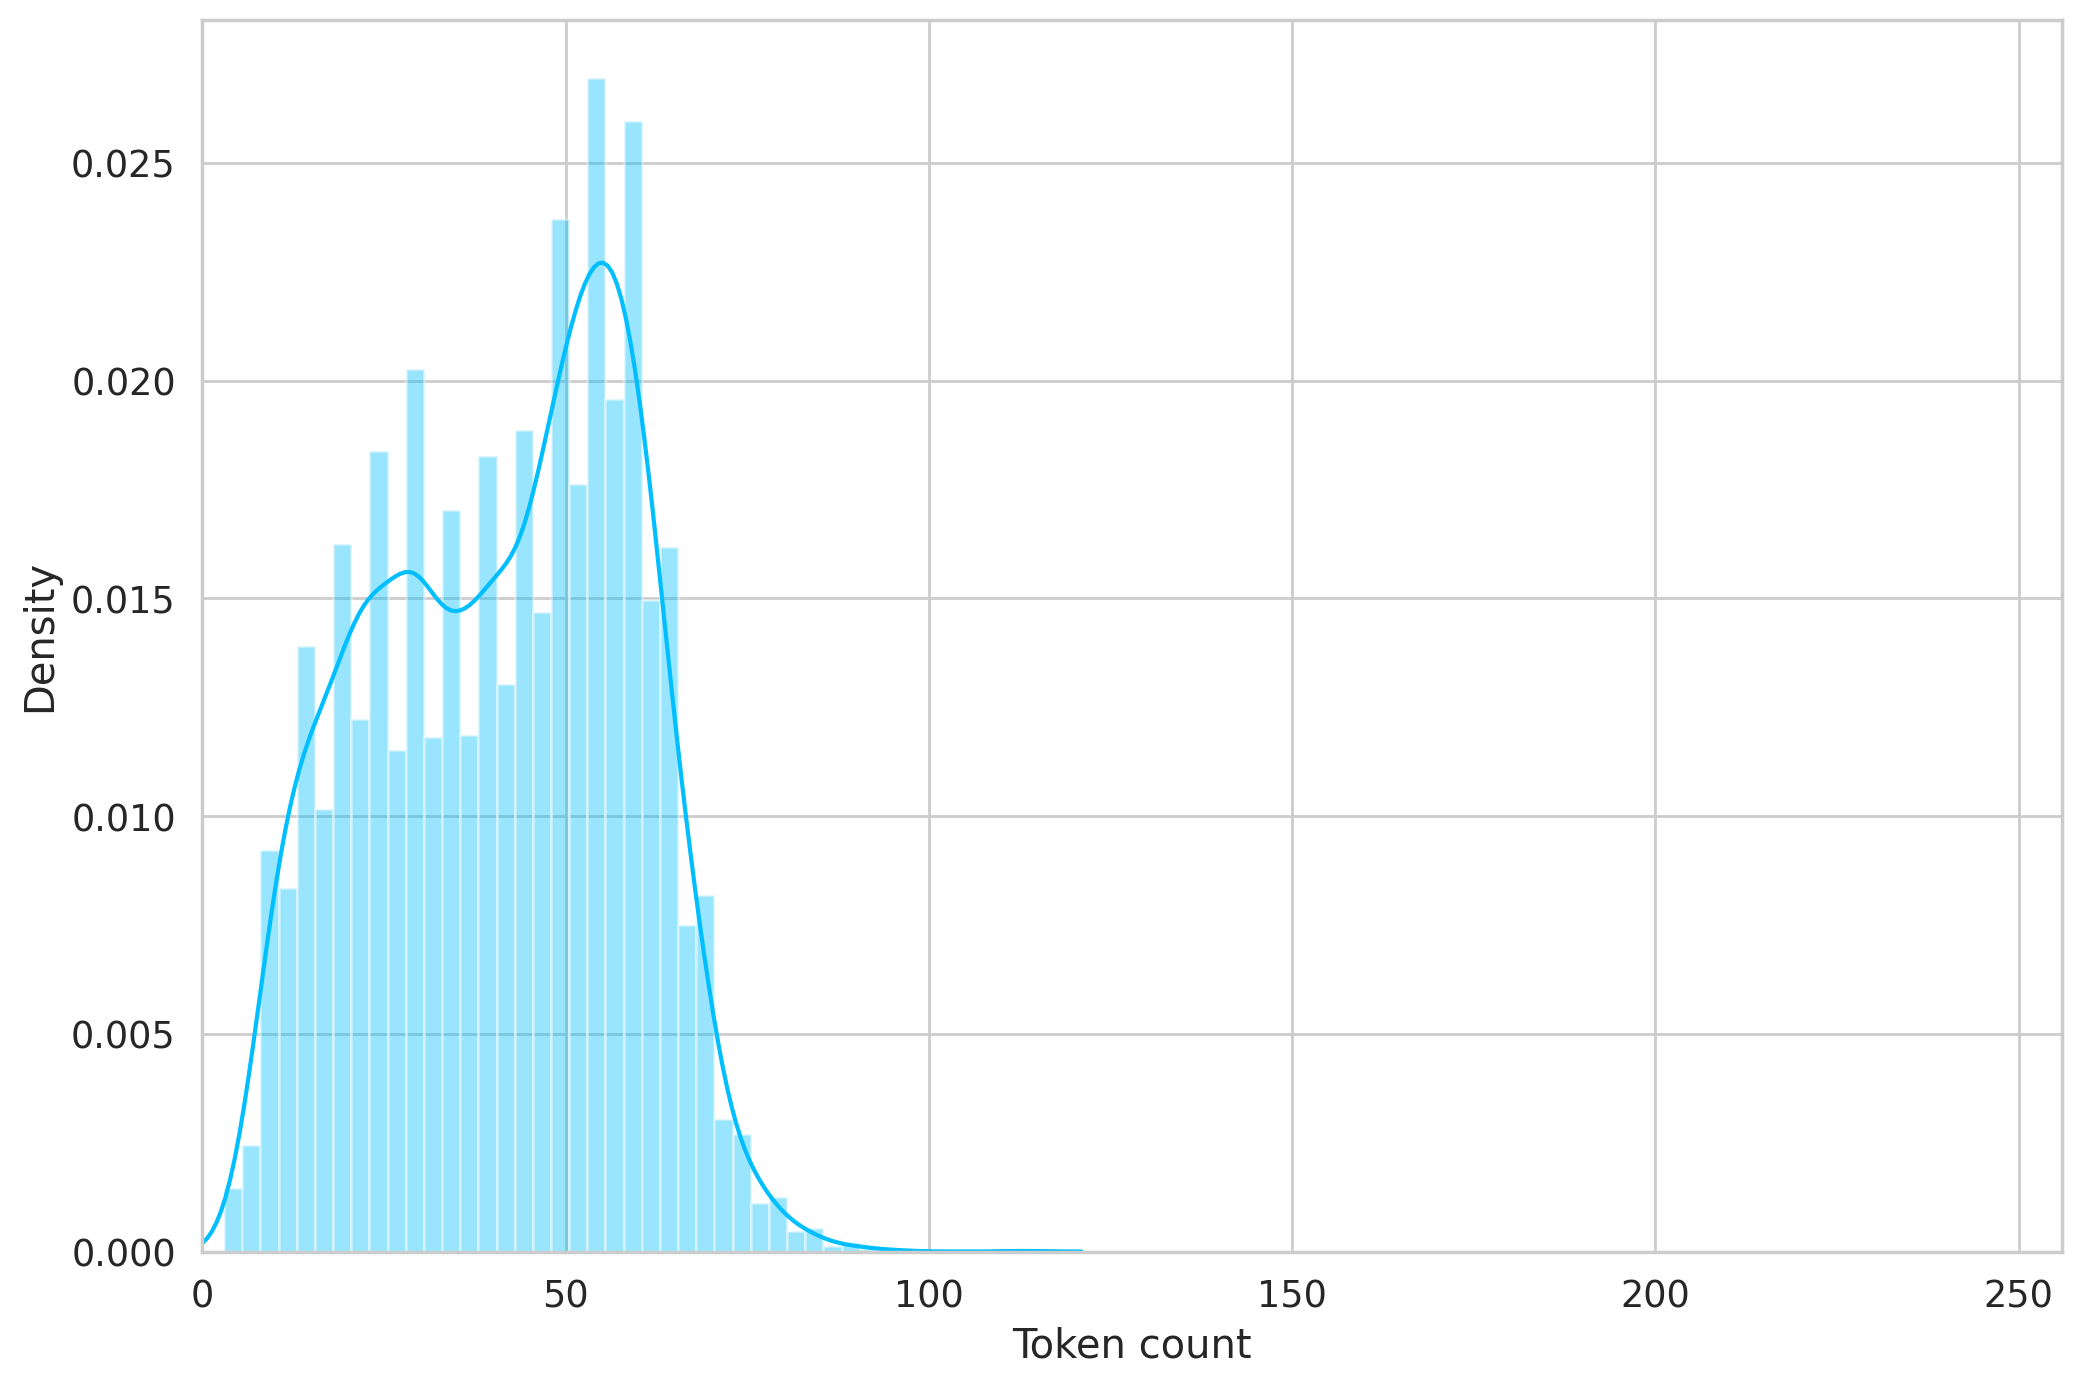

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )

    return {
      'tweet': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_valid.shape, df_test.shape

((12114, 2), (1500, 2), (2249, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
print(encoding['attention_mask'] , encoding['token_type_ids'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
x = muril_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

In [ ]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

torch.Size([1, 32, 768]) torch.Size([1, 768])


In [ ]:
muril_model.config.hidden_size

768

In [ ]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.muril = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150,bidirectional=True,dropout=0.2)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1)
    self.out = nn.Linear(64, n_classes)

  def forward(self, input_ids, attention_mask, token_type_ids):
    x = self.muril(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    pooled_output = x['pooler_output']
    output = self.drop1(pooled_output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

In [ ]:

class_names = ['-1','0', '1']
model = SentimentClassifier(len(class_names), muril_model)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
data.keys()

dict_keys(['tweet', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
input_ids
model(input_ids, attention_mask, token_type_ids)

tensor([[-0.0352, -0.0057,  0.0456],
        [-0.0381,  0.0023,  0.0568],
        [-0.0562,  0.0016,  0.0592],
        [-0.0432, -0.0091,  0.0477],
        [-0.0490, -0.0042,  0.0497],
        [-0.0543, -0.0044,  0.0585],
        [-0.0432, -0.0121,  0.0543],
        [-0.0396, -0.0168,  0.0460],
        [-0.0528, -0.0052,  0.0359],
        [-0.0516, -0.0210,  0.0466],
        [-0.0542, -0.0098,  0.0504],
        [-0.0483, -0.0069,  0.0567],
        [-0.0394, -0.0161,  0.0546],
        [-0.0471, -0.0109,  0.0481],
        [-0.0474, -0.0121,  0.0525],
        [-0.0523, -0.0040,  0.0509]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.3200, 0.3287, 0.3513],
        [0.3180, 0.3312, 0.3508],
        [0.3187, 0.3299, 0.3515],
        [0.3191, 0.3268, 0.3541],
        [0.3208, 0.3288, 0.3504],
        [0.3159, 0.3295, 0.3546],
        [0.3174, 0.3321, 0.3504],
        [0.3184, 0.3298, 0.3518],
        [0.3184, 0.3294, 0.3522],
        [0.3176, 0.3318, 0.3507],
        [0.3198, 0.3314, 0.3488],
        [0.3170, 0.3322, 0.3508],
        [0.3166, 0.3335, 0.3498],
        [0.3181, 0.3300, 0.3519],
        [0.3185, 0.3293, 0.3523],
        [0.3200, 0.3313, 0.3487]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)
      targets+=1

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids

      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_valid)
  )

  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'muril_bilstm_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------


100%|██████████| 758/758 [05:51<00:00,  2.16it/s]


--> Train loss 1.0200151128787793 accuracy 0.5477959385834572


--> Val   loss 0.8306068606833195 accuracy 0.7926666666666666

Epoch 2/10
----------


100%|██████████| 758/758 [05:54<00:00,  2.14it/s]


--> Train loss 0.7231422283325473 accuracy 0.7527653954102691


--> Val   loss 0.5999659734203461 accuracy 0.8513333333333333

Epoch 3/10
----------


100%|██████████| 758/758 [05:55<00:00,  2.13it/s]


--> Train loss 0.5195281354214082 accuracy 0.856859831599802


--> Val   loss 0.4698245259041482 accuracy 0.854

Epoch 4/10
----------


100%|██████████| 758/758 [05:55<00:00,  2.13it/s]


--> Train loss 0.3877516808602615 accuracy 0.8881459468383689


--> Val   loss 0.44947481765709024 accuracy 0.8566666666666667

Epoch 5/10
----------


100%|██████████| 758/758 [05:54<00:00,  2.14it/s]


--> Train loss 0.31724336650959734 accuracy 0.9075449892686149


--> Val   loss 0.46383562113376375 accuracy 0.854

Epoch 6/10
----------


100%|██████████| 758/758 [05:53<00:00,  2.14it/s]


--> Train loss 0.26466222293674946 accuracy 0.9278520719828298


--> Val   loss 0.5069214998486828 accuracy 0.856

Epoch 7/10
----------


100%|██████████| 758/758 [05:53<00:00,  2.14it/s]


--> Train loss 0.23290038284769474 accuracy 0.9380056133399374


--> Val   loss 0.5678864000563292 accuracy 0.846

Epoch 8/10
----------


100%|██████████| 758/758 [05:53<00:00,  2.14it/s]


--> Train loss 0.2061977842675232 accuracy 0.9479940564635959


--> Val   loss 0.5811871319533662 accuracy 0.8473333333333333

Epoch 9/10
----------


100%|██████████| 758/758 [05:53<00:00,  2.15it/s]


--> Train loss 0.1894580276565022 accuracy 0.9534422981674097


--> Val   loss 0.5865540248837243 accuracy 0.8473333333333333

Epoch 10/10
----------


100%|██████████| 758/758 [05:53<00:00,  2.14it/s]


--> Train loss 0.1807274581793214 accuracy 0.9555060260855209


--> Val   loss 0.5722155828583748 accuracy 0.854



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then move the model to your Drive
!cp muril_bilstm_model_state.bin /content/drive/MyDrive/


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Re-import or redefine your SentimentClassifier class
model = SentimentClassifier(len(class_names), muril_model)
model = model.to(device)


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/muril_bilstm_model_state.bin'))
model.eval()


SentimentClassifier(
  (muril): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu()

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()

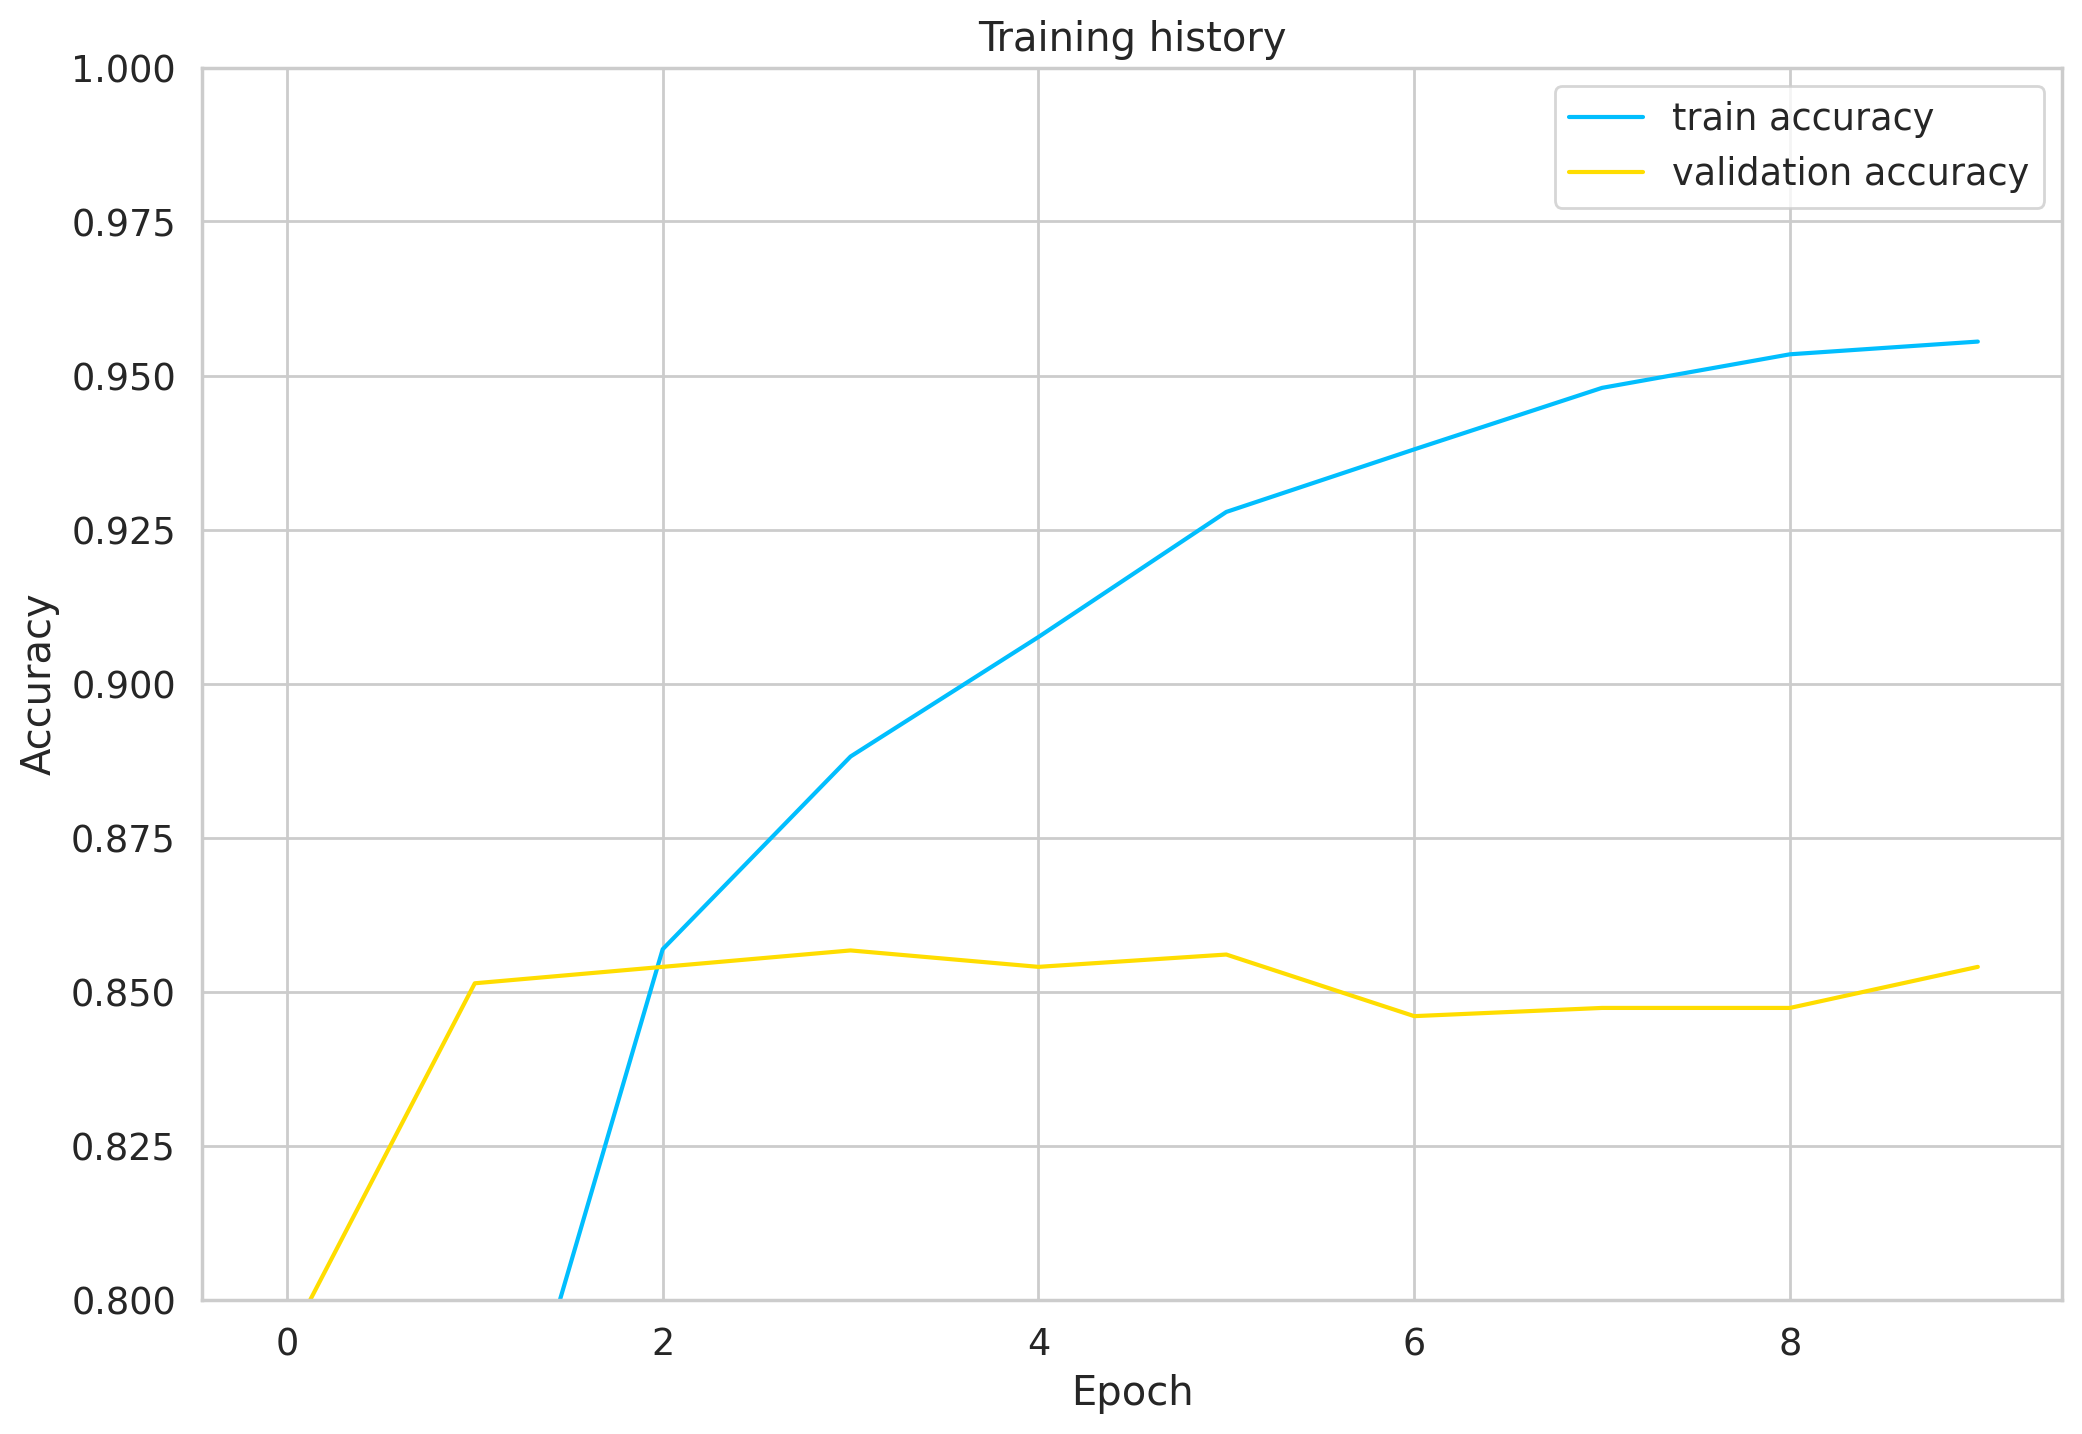

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

In [ ]:
model2 = SentimentClassifier(len(class_names), muril_model)
model2.load_state_dict(torch.load('muril_bilstm_model_state.bin'))
model2.eval()

SentimentClassifier(
  (muril): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
model2 = model2.to(device)

In [ ]:
# Inspect for unusual values in the 'label' column of df_test
print(df_test['label'].unique())

# Convert the 'label' column to numeric, handling errors
df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')

# Replace infinite values with NaN
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in 'label' column if any
df_test.dropna(subset=['label'], inplace=True)

# Ensure 'label' column is of integer type
df_test['label'] = df_test['label'].astype(int)

[ 1.  0. -1. nan]


In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8566666666666667

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      # Change 'tweet_text' to 'tweet' to access the correct key
      texts = d["tweet"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:

y_tweet_texts , y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          -1       0.92      0.89      0.90       500
           0       0.77      0.86      0.82       500
           1       0.89      0.82      0.85       500

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



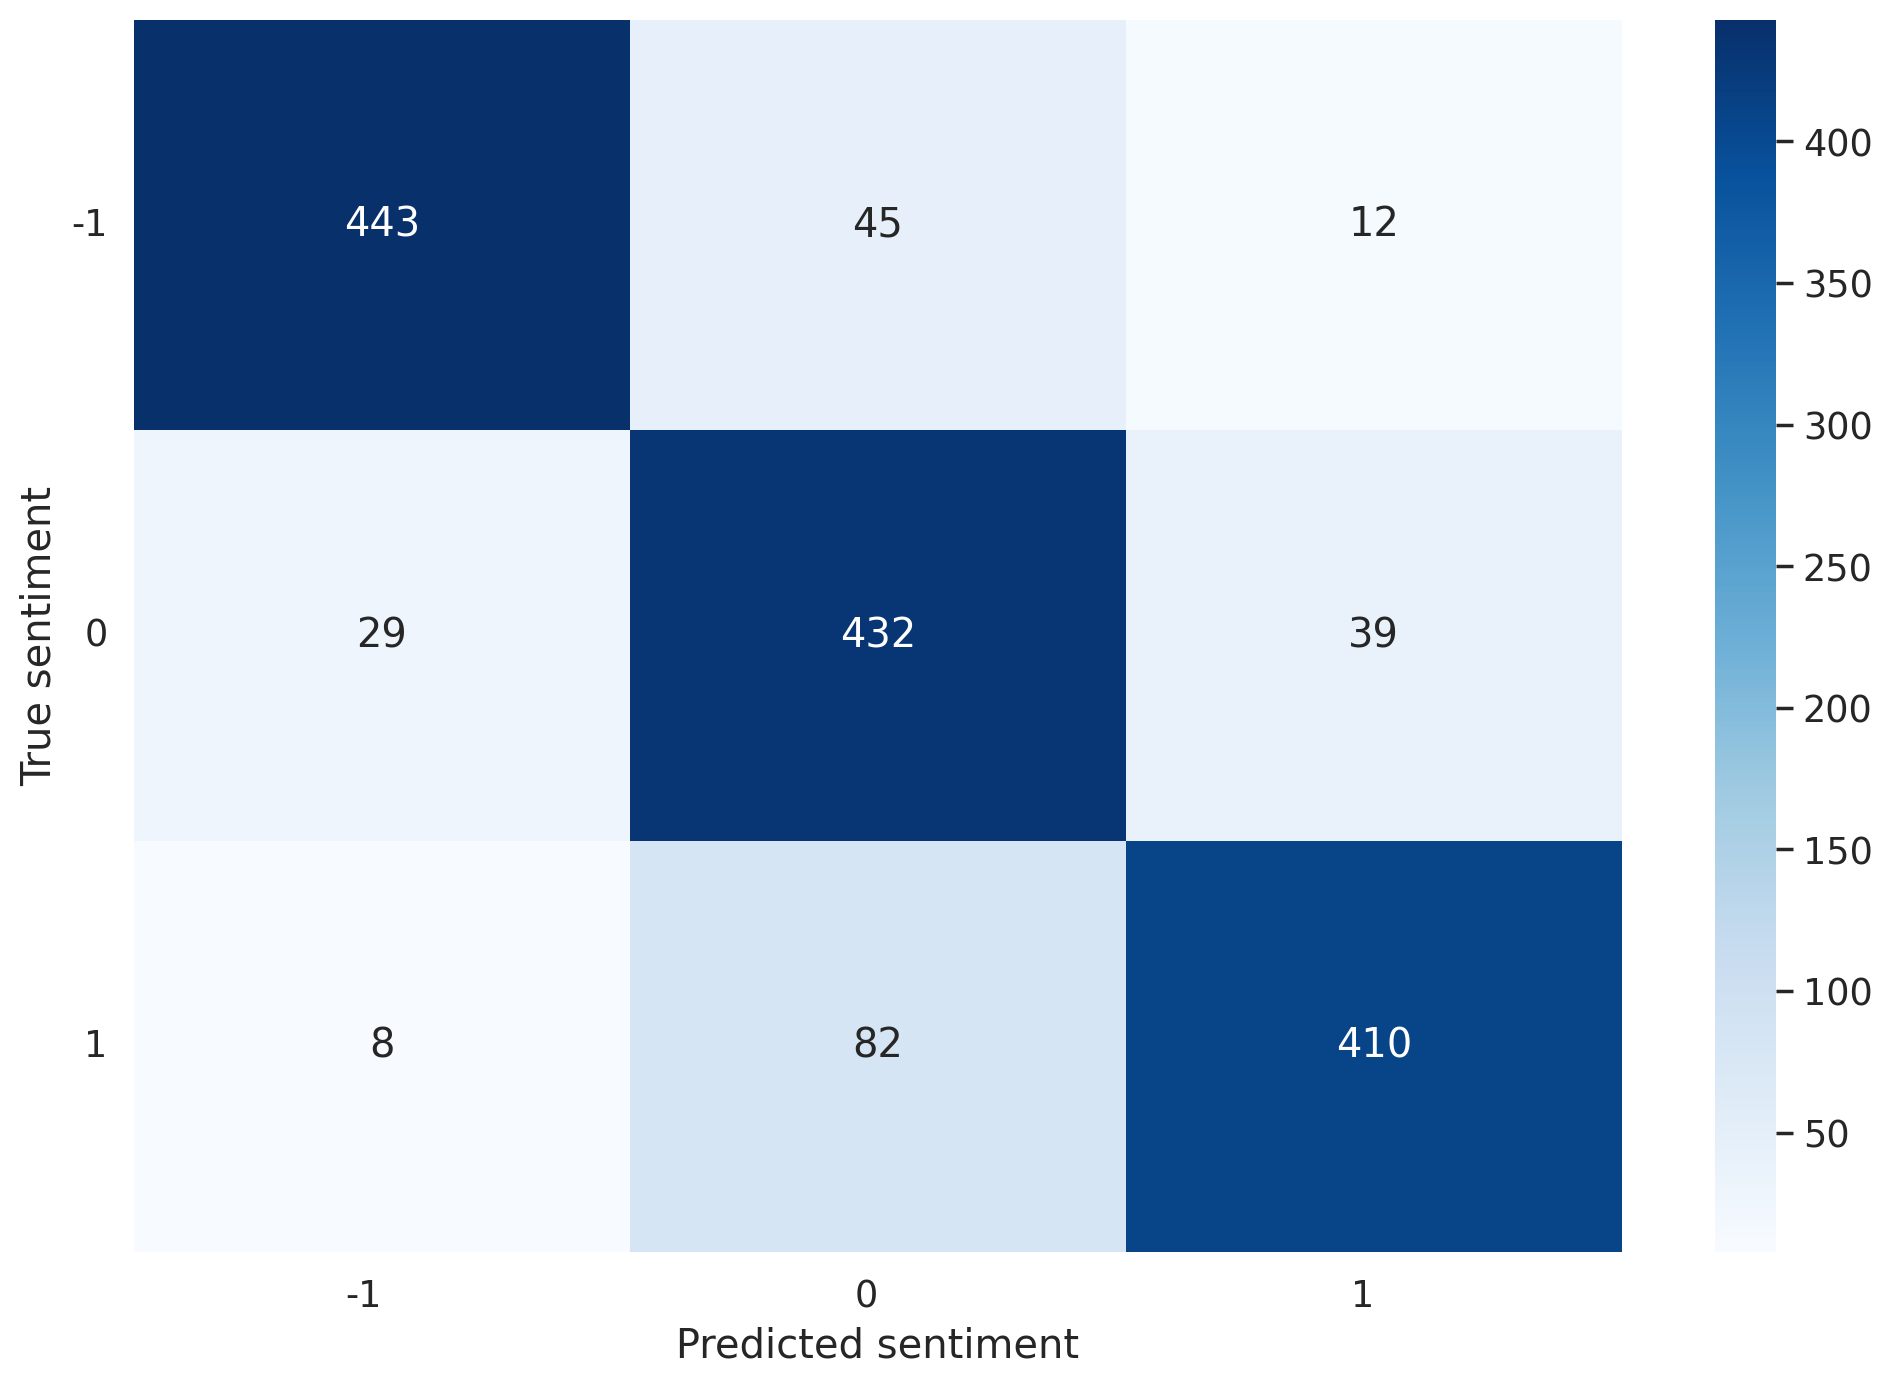

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]

tensor([-1,  1,  1, -1,  0,  1,  1,  0,  1, -1])

In [ ]:
idx = 52

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})



 हिंदुहृदयसम्राट शिवसेनाप्रमुख बाळासाहेब ठाकरे हे कायम आमच्यासाठी आदरस्थानीच राहतील! 




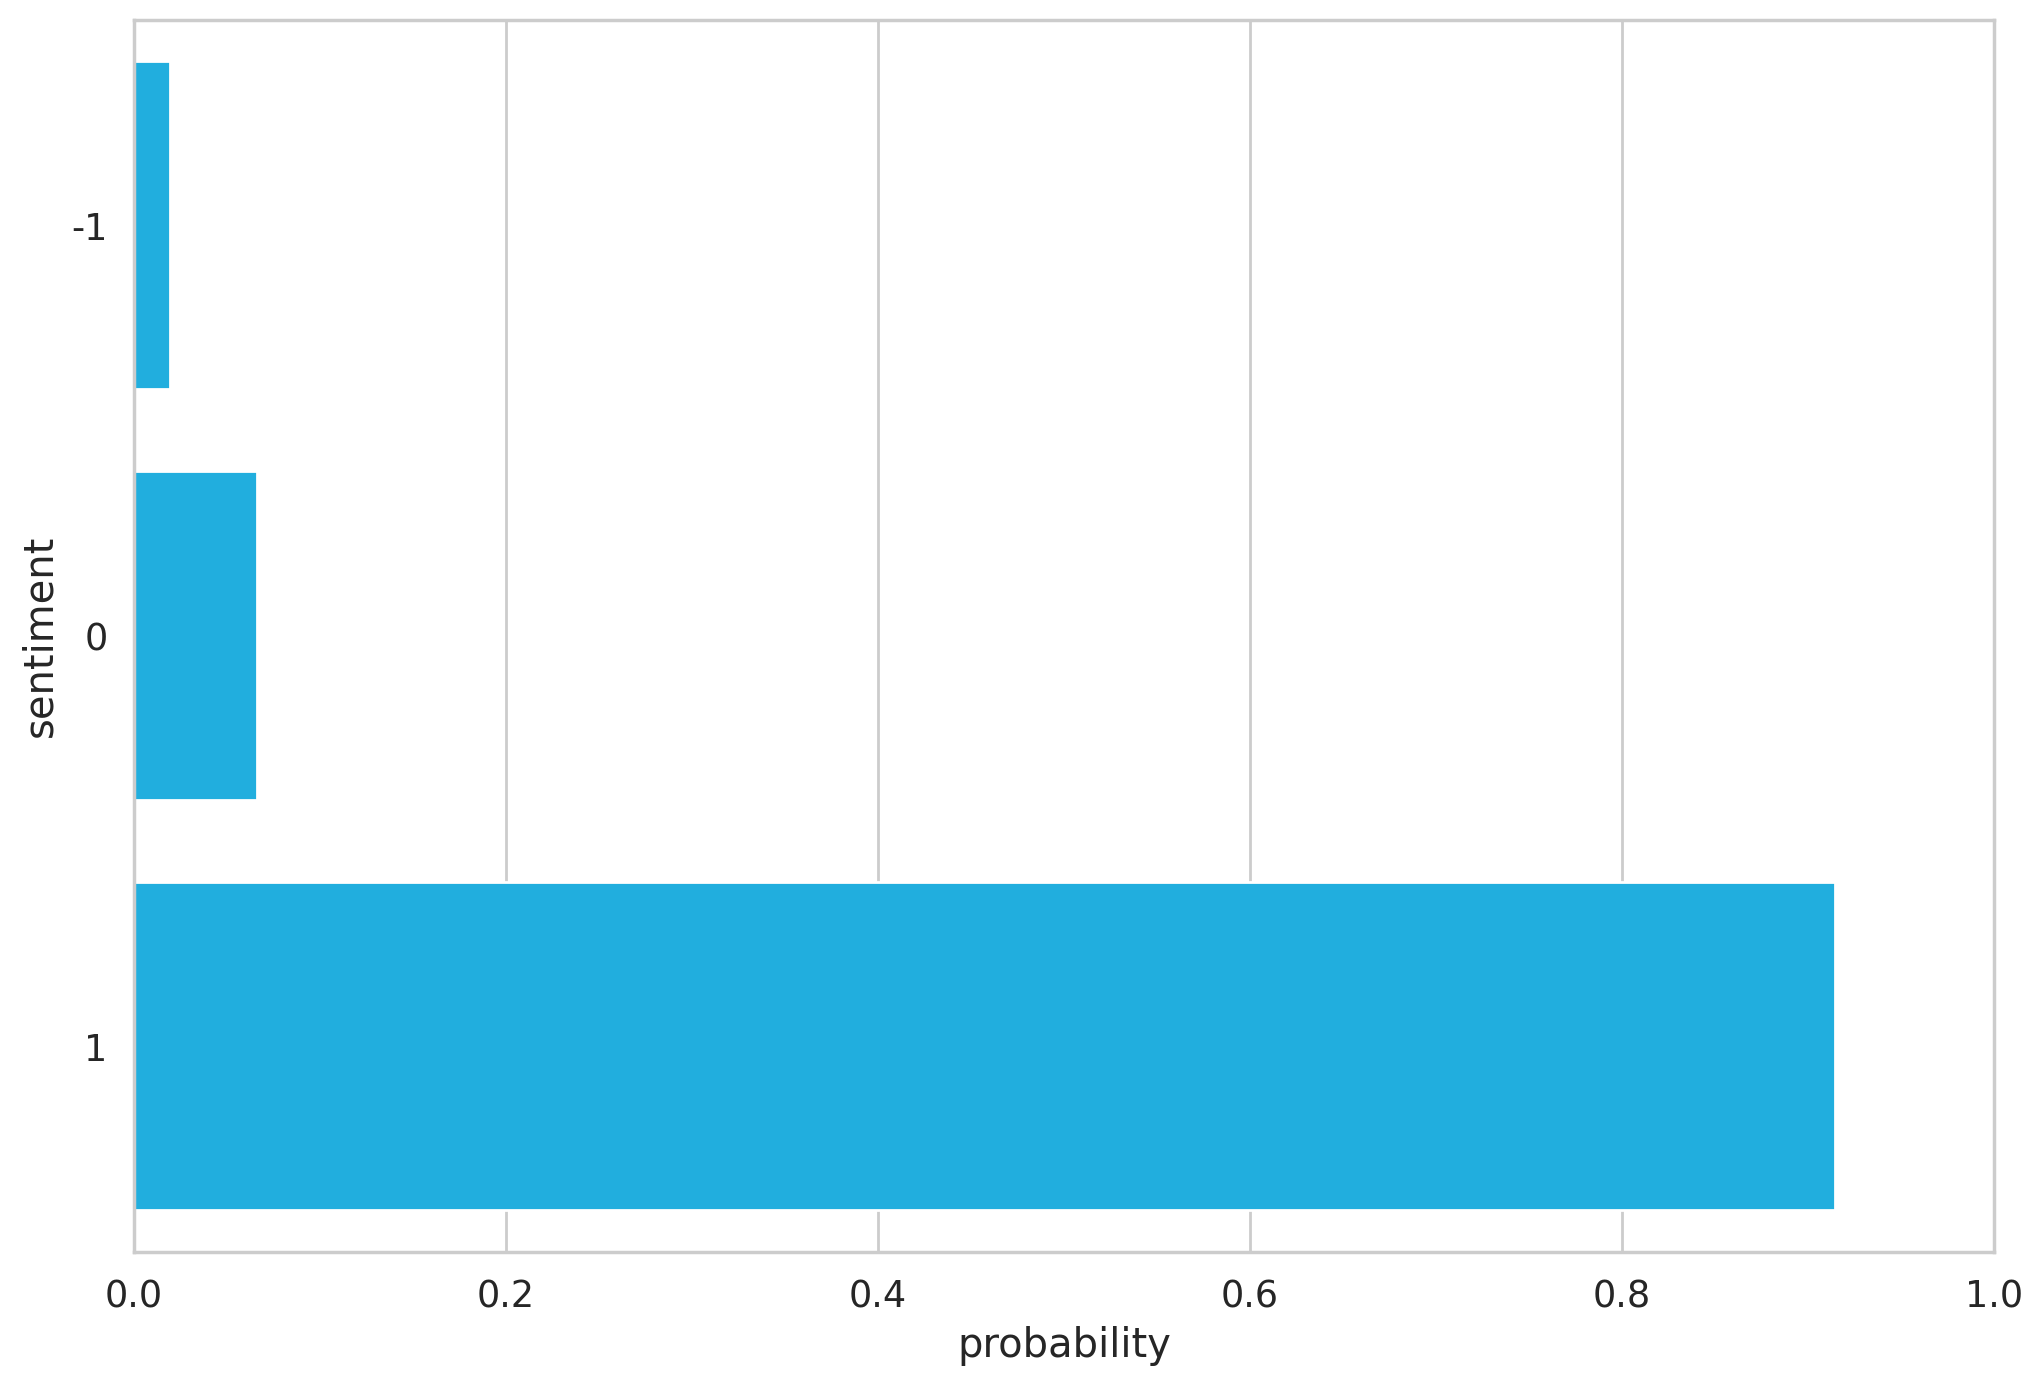

In [ ]:
print('\n\n',tweet_text, '\n\n')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
custom_text = input("Enter your text for sentiment analysis: ")

# Tokenize
# Use 'tokenizer' instead of 'muril_tokenizer'
encoded_input = tokenizer.encode_plus(
    custom_text,
    max_length=128,
    add_special_tokens=True,
    return_token_type_ids=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

# Move to device
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(input_ids, attention_mask, token_type_ids)
    probs = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

print(f"Predicted Sentiment: {class_names[predicted_class]}")

KeyboardInterrupt: Interrupted by user